# Tutorial 2: A Second-Order-in-Time Problem

Written by Adam Morgan

*Last Updated August 26, 2024*

Next, I'll show you how to handle second-order-in-time problems with *joe*. We focus on the **sine-Gordon (sG)** equation 

$$
u_{tt}-u_{xx} +\sin(u) = 0, \quad x\in \mathbb{R}, \ t>0.
$$

This PDE appears in differential geometry and mathematical physics, see for instance Dauxois and Peyrard 2006. sG is well-known to be completely integrable, admitting "kink" soliton solutions: 

$$
K(x,t;c,p) = 4\mathrm{arctan}\left(\exp\left(\frac{p(x-ct)}{\sqrt{1-c^2}}\right)\right) \in \left[0,2\pi\right], 
$$

where $c\in (-1,1)$ and $p=\pm 1$ are parameters representing the speed and polarity of the soliton respectively. We can numerically test the perfect elasticity of sG soliton collisions by using *joe* to simulate sG with the approximate two-soliton initial conditions 

$$
\left\{
\begin{aligned}
u(x,t=0) &= K(x+20, t=0; c=0.9, p=1) - K(x-20, t=0; c=-0.9, p=1),
\\ \\ 
u_{t}(x,t=0) &= K_{t}(x+20, t=0; c=0.9, p=1) - K_{t}(x-20, t=0; c=-0.9, p=1). 
\end{aligned}
\right.
$$

We expect the two (initially well-separated) kinks to move towards each other with equal and opposite speeds, then pass through each other unperturbed, with the exception of a "phase shift" where the solitons reverse their polarities. 

Note how the initial data vanish quickly away from a neighbourhood of the origin, so in performing our simulations we are allowed to use periodic BCs if our domain length $\ell$ is moderately large (we'll take $\ell=100$). 


Before diving into the code, I'll explain how *joe* treats second-order equations. By augmenting the problem with a new responding variable $v=u_t$, we may re-write sG as a $2\times 2$ system of first-order-in-time PDEs: 

$$
\partial_{t}\begin{bmatrix} u \\ v\end{bmatrix} + \begin{bmatrix} 0 & 1 \\ -\partial_{x}^2 & 0 \end{bmatrix} \begin{bmatrix} u \\ v\end{bmatrix} + \begin{bmatrix} 0 \\ \sin\left(u\right)\end{bmatrix} = 0. 
$$

Since the matrix of the linear part of the PDE is no longer diagonal, this adds some slight complications to the numerics. However, it's nothing that can't be handled with a bit of complex analysis, following Kassam & Trefethen 2005. Let's call the block matrix appearing above by 

$$
A = \begin{bmatrix} 0 & 1 \\ -\partial_{x}^2 & 0 \end{bmatrix}. 
$$

In Fourier space, the operator $A$ formally becomes a *banded* matrix

$$
\widehat{A} = \begin{bmatrix} 0 & 1 \\ -k^2 & 0 \end{bmatrix}
$$

where $-k^2$ is shorthand for the infinite diagonal matrix

$$
-k^2 = \text{diag}\left(0, -k_1^2, -k_2^2,...\right)
$$

and each $k_j$ is a Fourier frequency on $\left[-\frac12\ell, +\frac12\ell\right]$. 

A little bit of linear algebra  shows that, once we restrict ourselves to sampling only $N$ frequencies in Fourier space, all eigenvalues $\lambda$ of $\widehat{A}$ satisfy

$$
\left|\lambda\right|\leq k_{\text{max}}
$$

where $k_{\text{max}}$ is the largest frequency that can be resolved on the grid. Therefore, following Kassam and Trefethen 2005, as long as we approximate our $\phi$-functions using integrals over contours large enough to enclose $\pm i \ \Delta t \ k_{\text{max}}$, everything works out fine. 

Before going further, it's helpful to take a step back and make sure all array shapes make sense. When dealing with second-order problems, *joe* must treat the solution as an array of size 

$$
2 \times \text{number of temporal samples} \times \text{number of spatial samples}. 
$$

In particular, the initial state callable and the forcing callable must have outputs with shape 

$$
2 \times \text{number of temporal samples}.
$$

If you give *joe* a second-order problem and an initial state with shape 

$$
\text{number of temporal samples}
$$

it will assume that the initial $v=u_t$ field is identically zero. 

For a generic second-order problem 

$$
u_{tt} + Lu = f(t,x,u,u_{x},...),
$$

*joe* always introduces $v=u_t$ and changes the problem to 

$$
\partial_{t}\begin{bmatrix} u \\ v\end{bmatrix} + \begin{bmatrix} 0 & 1 \\ L & 0 \end{bmatrix} \begin{bmatrix} u \\ v\end{bmatrix} = \begin{bmatrix} 0 \\ f(t,x,u,u_{x},...)\end{bmatrix}.  
$$

For this reason, the $\texttt{symbol}$ callable used to define a $\texttt{model}$ is still just a scalar as in the first-order case. Generalizing the discussion above, one finds that the eigenvalues of the discretized Fourier-side operator obey

$$
\left|\lambda\right| \leq \max_{k_j} \sqrt{\left|L\left(k_{j}\right)\right|}. 
$$

Accordingly, we can *always* select our $\phi$-function contour radius under-the-hood using only our choice of symbol $L(k)$. 

### Recommendations for Further Reading 
- Dauxois and Peyrard, *Physics of Solitons*. Cambridge Univ. Press, 2006. https://www.cambridge.org/us/universitypress/subjects/physics/nonlinear-science-and-fluid-dynamics/physics-solitons?format=HB&isbn=9780521854214

- Kassam & Trefethen, SIAM JSC, 2005 https://epubs.siam.org/doi/10.1137/S1064827502410633

## Code Demo: Soliton Collision

We now turn to the actual code. First come the imports, all of which were explained in tutorial 1. 

In [1]:
import numpy as np

from numpy.fft import rfft, irfft

# import some joe stuff
import joe_lab.joe as joe
import joe_lab.models as joe_models
import joe_lab.initial_states as joe_initial_states

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%matplotlib inline
%config InlineBackend.figure_format='retina'

import os

# add the folder "joe_visuals" to our path
my_path = os.path.join("joe_visuals")

# first, if the folder doesn't exist, make it
if not os.path.isdir(my_path):
    os.makedirs(my_path)

# make sure Image and Video can be displayed in the notebook. 
from IPython.display import Image, Video

As in tutorial 1, sG and the required initial states are built-in: 

In [2]:
my_sg_model = joe_models.builtin_model('sinegordon', nonlinear=True)
my_sg_initial_state = joe_initial_states.builtin_initial_state('sinegordon_soliton_interaction')

To get the $\texttt{model}$ from scratch, you could instead use the code here: 

In [8]:
def my_sg_fourier_forcing(V, k, x, nonlinear=True): 

    if int(V.size - 2) == x.size:

        pass

    else:

        raise TypeError("The array V must be 2+(size of the array x) if our soln is real, "
                            "or 2*(size of the array x) if our soln is complex.")

    N = int(V.size - 2)

    V = np.reshape(V, (N + 2,))

    NN = int(0.5 * N) + 1

    u = irfft(V[0:NN])  # only ifft first N entries of V because of storage conventions

    spatial_forcing = -float(nonlinear)*np.sin(u)

    out = 1j * np.zeros(N + 2, dtype=float)
    out[NN:] = rfft(spatial_forcing)

    return out

my_sg_model_custom = joe.model('sinegordon', 2, lambda k: -k**2, my_sg_fourier_forcing, nonlinear=True)
# note how t_ord=2 here!

The important thing to remember is that, following the discussion above, the outputs have the correct shape! 

As for the initial state object, you could use the code below: 

In [4]:
def sinegordon_soliton(x, c=0., p=1.):
    if np.abs(c) >= 1:
        raise ValueError('Sine-Gordon soliton speed must be in the interval (-1,1).')
    out = np.zeros_like(x, dtype=float)
    arg = p*x/np.sqrt(1.-c**2)
    xmax = 1.8e2 # need to threshold the arguments to avoid overflow: above xmax we don't allow for numerical error
    out[arg > xmax] = 2.*np.pi
    out[arg < -xmax] = 0.
    out[np.abs(arg)<= xmax] = 4.*np.arctan(np.exp(arg[np.abs(arg)<= xmax]))
    return out

def sinegordon_soliton_speed(x, c=0., p=1.): # speed is at t=0
    if np.abs(c) >= 1:
        raise ValueError('Sine-Gordon soliton speed must be in the interval (-1,1).')
    out = np.zeros_like(x, dtype=float)
    gamma = 1./np.sqrt(1.-c**2)
    arg = p*x*gamma
    xmax = 1.8e2 # as above
    out[arg > xmax] = 0.
    out[arg < -xmax] = 0.
    aa = arg[np.abs(arg)<= xmax]
    out[np.abs(arg)<= xmax] = -(c*4.*p*gamma)*(np.exp(aa)/(1.+np.exp(2.*aa)))
    return out

def my_initial_state_custom_fnc(x): 
    out = np.zeros((2,np.shape(x)[0]), dtype=float)
    out[0,:] = sinegordon_soliton(x+20, c=0.9, p=1) - sinegordon_soliton(x-20, c=-0.9, p=1)
    out[1,:] = sinegordon_soliton_speed(x+20, c=0.9, p=1) - sinegordon_soliton_speed(x-20, c=-0.9, p=1)
    return out 

my_initial_state_custom = joe.initial_state('sinegordon_soliton_interaction', my_initial_state_custom_fnc)

Now, let's get to simulating the dynamics. There is no difference between first and second order problems when making the spacetime grid and defining, running, or loading simulations. If you use $\texttt{plot\_initial\_condition}$, note that the resulting graph only shows $u(x,t=0)$ and not $u_{t}(x,t=0)$. 

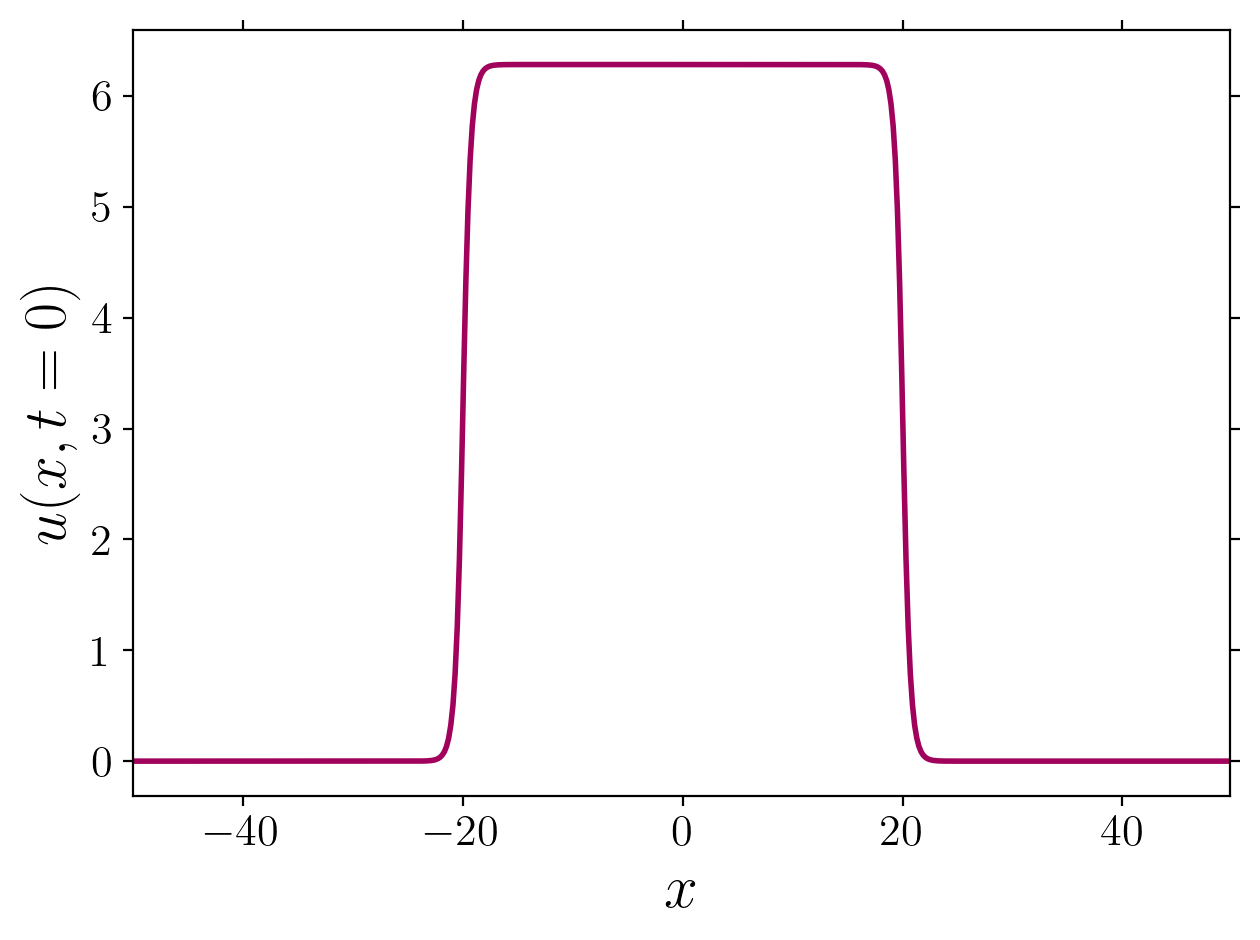

No saved simulation found, running simulation.
Simulation runtime = 0.505 s


In [5]:
length, T, N, dt = 100.,45., 2**9, 1e-2
stgrid = {'length': length, 'T': T, 'N': N, 'dt': dt}

my_sg_sim = joe.simulation(stgrid, my_sg_model, my_sg_initial_state, bc='periodic', ndump=20)

my_sg_sim.plot_initial_condition(color='xkcd:deep magenta', usetex=True, show_figure=True, save_figure=False)

my_sg_sim.load_or_run(method_kw='etdrk4', print_runtime=True, save=False)

Likewise, saving a Hovmoeller plot or movie is the same: 

Rendering Hovmoeller plot... |████████████████████████████████████████| in 0.3s 


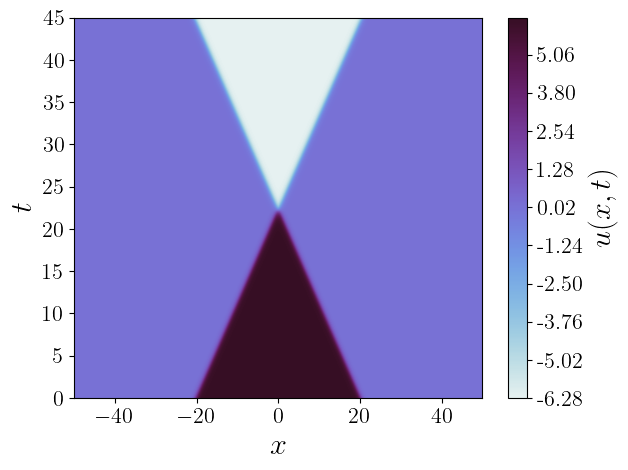

In [6]:
my_sg_sim.hov_plot(fieldname='u', usetex=True, cmap='cmo.dense', show_figure=False, save_figure=True, dpi=100)

Image('joe_visuals/' + my_sg_sim.picname, embed=True)

In [7]:
my_sg_sim.save_movie(dpi=80, fps=100, usetex=False, fieldcolor='xkcd:deep magenta', fieldname='u')
Video('joe_visuals/' + my_sg_sim.moviename, embed=True)

Rendering movie... |████████████████████████████████████████| in 5.6s           


So, though there are differences between first and second order when it comes to defining the model and initial state, everything else is basically the same. This gives *joe* a nice uniformity despite the numerical hoops that one must jump through when increasing the temporal order (going from a diagonal to a banded matrix). 

Additionally, notice that our Hovmoeller plot and our movie confirm that *joe* is capable of reproducing elastic soliton collisions: when the waves hit each other, they reverse polarity and each continues on their own merry way. This polarity reversal is perfectly acceptable from a physical point of view, and indeed it is actually necessary to ensure that the net field $u(x,t)$ conserves its **topological charge** $\mathcal{N}$, defined by 

$$
\mathcal{N} = \frac{u(x=+\infty)-u(x=-\infty)}{2\pi}\in \mathbb{Z}. 
$$

I remark that $\mathcal{N}=0$ in the problem above. 